In [3]:
!pip install ultralytics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.1/800.1 kB 17.8 MB/s eta 0:00:0000:01





































  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)


  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)


  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)


  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)


  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)


  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)



  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)


  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 

# Data Preprocessing Split And Organize the datatset

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define old and new base directories
old_train_base = '/kaggle/input/haik-24-arabic-sign-language-image-classification/train/train/haik-image claassification'
new_base = '/kaggle/working/dataset'
new_train_base = os.path.join(new_base, 'train')
new_val_base = os.path.join(new_base, 'val')
new_test_base = os.path.join(new_base, 'test')

# Create new directories
os.makedirs(new_train_base, exist_ok=True)
os.makedirs(new_val_base, exist_ok=True)
os.makedirs(new_test_base, exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Copy and split data
for class_name in os.listdir(old_train_base):
    old_class_path = os.path.join(old_train_base, class_name)
    if os.path.isdir(old_class_path):
        # Get list of all images in the class directory
        images = os.listdir(old_class_path)
        train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio))
        val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)))

        # Define new paths for train, val, and test splits
        new_class_train_path = os.path.join(new_train_base, class_name)
        new_class_val_path = os.path.join(new_val_base, class_name)
        new_class_test_path = os.path.join(new_test_base, class_name)

        os.makedirs(new_class_train_path, exist_ok=True)
        os.makedirs(new_class_val_path, exist_ok=True)
        os.makedirs(new_class_test_path, exist_ok=True)

        # Copy images to new train directory
        for image_name in train_images:
            shutil.copy(os.path.join(old_class_path, image_name), os.path.join(new_class_train_path, image_name))

        # Copy images to new val directory
        for image_name in val_images:
            shutil.copy(os.path.join(old_class_path, image_name), os.path.join(new_class_val_path, image_name))

        # Copy images to new test directory
        for image_name in test_images:
            shutil.copy(os.path.join(old_class_path, image_name), os.path.join(new_class_test_path, image_name))


In [4]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n-cls.yaml")  # build a new model from YAML
model = YOLO("yolov8n-cls.pt")  # load a pretrained model
model = YOLO("yolov8n-cls.yaml").load("yolov8n-cls.pt")  # build from YAML and transfer weights

# Train the model
results = model.train(data="/kaggle/working/dataset", epochs=30, imgsz=64)

YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs



100%|██████████| 5.28M/5.28M [00:00<00:00, 57.7MB/s]


YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs

Transferred 158/158 items from pretrained weights

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

engine/trainer: task=classify, mode=train, model=yolov8n-cls.yaml, data=/kaggle/working/dataset, epochs=30, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

100%|██████████| 6.23M/6.23M [00:00<00:00, 165MB/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train... 30261 images, 0 corrupt: 100%|██████████| 30261/30261 [00:05<00:00, 5194.85it/s]


train: New cache created: /kaggle/working/dataset/train.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

val: Scanning /kaggle/working/dataset/val... 8648 images, 0 corrupt: 100%|██████████| 8648/8648 [00:01<00:00, 4963.71it/s]


val: New cache created: /kaggle/working/dataset/val.cache

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 

optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)

TensorBoard: model graph visualization added ✅

Image sizes 64 train, 64 val

Using 2 dataloader workers

Logging results to runs/classify/train

Starting training for 30 epochs...



      Epoch    GPU_mem       loss  Instances       Size


       1/30      0.38G      3.714         16         64:   1%|          | 10/1892 [00:01<02:25, 12.98it/s]

       1/30      0.38G      3.751         16         64:   1%|          | 22/1892 [00:01<01:42, 18.30it/s]

100%|██████████| 755k/755k [00:00<00:00, 31.1MB/s]

       1/30      0.38G       2.39         16         64: 100%|█████████▉| 1891/1892 [01:47<00:00, 22.68it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

       1/30      0.38G       2.39          5         64: 100%|██████████| 1892/1892 [01:47<00:00, 17.53it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:08<00:00, 31.28it/s]


                   all      0.723      0.967



      Epoch    GPU_mem       loss  Instances       Size


       2/30     0.359G       1.34          5         64: 100%|██████████| 1892/1892 [01:40<00:00, 18.84it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 37.38it/s]

                   all      0.808      0.983




      Epoch    GPU_mem       loss  Instances       Size


       3/30     0.359G      1.265          5         64: 100%|██████████| 1892/1892 [01:38<00:00, 19.21it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 36.10it/s]

                   all      0.798      0.975




      Epoch    GPU_mem       loss  Instances       Size


       4/30     0.359G      1.218          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.64it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:08<00:00, 32.30it/s]

                   all      0.831      0.984




      Epoch    GPU_mem       loss  Instances       Size


       5/30     0.359G      1.015          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.58it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 34.33it/s]

                   all      0.874      0.987




      Epoch    GPU_mem       loss  Instances       Size


       6/30     0.359G     0.8885          5         64: 100%|██████████| 1892/1892 [01:37<00:00, 19.37it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:09<00:00, 30.10it/s]

                   all       0.91      0.991




      Epoch    GPU_mem       loss  Instances       Size


       7/30     0.359G     0.7788          5         64: 100%|██████████| 1892/1892 [01:35<00:00, 19.81it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:08<00:00, 31.34it/s]


                   all      0.915      0.992



      Epoch    GPU_mem       loss  Instances       Size


       8/30     0.359G     0.7114          5         64: 100%|██████████| 1892/1892 [01:35<00:00, 19.72it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:08<00:00, 32.01it/s]

                   all      0.935      0.992




      Epoch    GPU_mem       loss  Instances       Size


       9/30     0.359G      0.655          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.19it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 46.42it/s]


                   all      0.942      0.995



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.359G     0.6096          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.62it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 51.49it/s]

                   all      0.952      0.994




      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.359G     0.5639          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.62it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 49.91it/s]

                   all      0.955      0.996




      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.359G     0.5332          5         64: 100%|██████████| 1892/1892 [01:40<00:00, 18.76it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 50.32it/s]

                   all      0.963      0.996




      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.359G     0.5093          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.52it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 52.23it/s]

                   all      0.966      0.994




      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.359G     0.4745          5         64: 100%|██████████| 1892/1892 [01:35<00:00, 19.84it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 46.50it/s]


                   all      0.966      0.996



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.359G     0.4618          5         64: 100%|██████████| 1892/1892 [01:35<00:00, 19.82it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 46.07it/s]

                   all      0.972      0.996




      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.359G      0.432          5         64: 100%|██████████| 1892/1892 [01:37<00:00, 19.50it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 38.11it/s]

                   all      0.972      0.996




      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.359G     0.4178          5         64: 100%|██████████| 1892/1892 [01:31<00:00, 20.79it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 35.67it/s]

                   all      0.976      0.997




      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.359G     0.4037          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.32it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 46.93it/s]

                   all      0.977      0.997




      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.359G     0.3829          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.13it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 51.84it/s]

                   all      0.979      0.997




      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.359G     0.3638          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.69it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:06<00:00, 42.35it/s]

                   all       0.98      0.998




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()




      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.361G     0.3472          5         64: 100%|██████████| 1892/1892 [01:35<00:00, 19.85it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 36.49it/s]

                   all       0.98      0.997




      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.359G     0.3343          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.30it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 34.21it/s]

                   all      0.979      0.998




      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.359G     0.3187          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.32it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 45.87it/s]

                   all       0.98      0.998




      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.359G      0.297          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.18it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 52.40it/s]

                   all      0.981      0.998




      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.359G     0.2855          5         64: 100%|██████████| 1892/1892 [01:38<00:00, 19.24it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 51.88it/s]

                   all      0.982      0.998




      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.359G     0.2705          5         64: 100%|██████████| 1892/1892 [01:36<00:00, 19.57it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 52.82it/s]

                   all      0.983      0.998




      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.359G     0.2689          5         64: 100%|██████████| 1892/1892 [01:34<00:00, 20.09it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:06<00:00, 39.45it/s]

                   all      0.983      0.998




      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.359G     0.2507          5         64: 100%|██████████| 1892/1892 [01:32<00:00, 20.36it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 36.32it/s]


                   all      0.984      0.997



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.359G     0.2336          5         64: 100%|██████████| 1892/1892 [01:32<00:00, 20.40it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 53.01it/s]


                   all      0.984      0.997



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.359G     0.2326          5         64: 100%|██████████| 1892/1892 [01:33<00:00, 20.31it/s]

               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:05<00:00, 53.56it/s]

                   all      0.984      0.997




30 epochs completed in 0.860 hours.

Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB

Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB



Validating runs/classify/train/weights/best.pt...

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

YOLOv8n-cls summary (fused): 73 layers, 1475872 parameters, 0 gradients, 3.3 GFLOPs

train: /kaggle/working/dataset/train... found 30261 images in 32 classes ✅ 

val: /kaggle/working/dataset/val... found 8648 images in 32 classes ✅ 

test: /kaggle/working/dataset/test... found 4343 images in 32 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 271/271 [00:07<00:00, 34.09it/s]


                   all      0.984      0.997

Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image

Results saved to runs/classify/train

Results saved to runs/classify/train


In [9]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1  # top1 accuracy
metrics.top5  # top5 accuracy

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

train: /kaggle/working/dataset/train... found 30261 images in 32 classes ✅ 

val: /kaggle/working/dataset/val... found 8648 images in 32 classes ✅ 

test: /kaggle/working/dataset/test... found 4343 images in 32 classes ✅ 


val: Scanning /kaggle/working/dataset/val... 8648 images, 0 corrupt: 100%|██████████| 8648/8648 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  self.pid = os.fork()

               classes   top1_acc   top5_acc: 100%|██████████| 541/541 [00:06<00:00, 79.11it/s]


                   all      0.984      0.997

Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image

Results saved to runs/classify/train3


0.9974560737609863

In [10]:
# Predict with the model
results = model("/kaggle/input/haik-24-arabic-sign-language-image-classification/test/test/124wqrf12 (10).JPG")  # predict on an image



image 1/1 /kaggle/input/haik-24-arabic-sign-language-image-classification/test/test/124wqrf12 (10).JPG: 64x64 aeyn 0.98, ghayn 0.02, thaal 0.00, daal 0.00, waaw 0.00, 4.2ms

Speed: 4.6ms preprocess, 4.2ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)


In [11]:
# Export the Model PyTorch Format ".pt"
model.export()

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)



PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 64, 64) BCHW and output shape(s) (1, 32) (2.9 MB)



TorchScript: starting export with torch 2.3.0+cu121...

TorchScript: export success ✅ 2.3s, saved as 'runs/classify/train/weights/best.torchscript' (5.8 MB)



Export complete (4.0s)

Results saved to /content/runs/classify/train/weights

Predict:         yolo predict task=classify model=runs/classify/train/weights/best.torchscript imgsz=64  

Validate:        yolo val task=classify model=runs/classify/train/weights/best.torchscript imgsz=64 data=/kaggle/working/dataset  

Visualize:       https://netron.app


'runs/classify/train/weights/best.torchscript'

In [12]:
# export the model ".onnx" format
model.export(format="onnx")

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)



PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 64, 64) BCHW and output shape(s) (1, 32) (2.9 MB)

requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.6 MB/s eta 0:00:00







requirements: AutoUpdate success ✅ 9.0s, installed 1 package: ['onnx>=1.12.0']

requirements: ⚠️ Restart runtime or rerun command for updates to take effect





ONNX: starting export with onnx 1.16.1 opset 17...

ONNX: export success ✅ 9.3s, saved as 'runs/classify/train/weights/best.onnx' (5.6 MB)



Export complete (10.6s)

Results saved to /content/runs/classify/train/weights

Predict:         yolo predict task=classify model=runs/classify/train/weights/best.onnx imgsz=64  

Validate:        yolo val task=classify model=runs/classify/train/weights/best.onnx imgsz=64 data=/kaggle/worki

'runs/classify/train/weights/best.onnx'

# **Testing the model with random samples from the test directory and ploting results**



0: 64x64 aeyn 0.97, ghayn 0.03, haa2 0.00, khaaa 0.00, zaay 0.00, 2.0ms

1: 64x64 ra2 1.00, zaay 0.00, daal 0.00, nuun 0.00, ba2 0.00, 2.0ms

2: 64x64 yaa 1.00, laa 0.00, nuun 0.00, sheeen 0.00, dhaad 0.00, 2.0ms

3: 64x64 meeem 1.00, ba2 0.00, saaad 0.00, laa 0.00, gaf 0.00, 2.0ms

4: 64x64 gaf 0.55, fa2 0.45, saaad 0.00, waaw 0.00, ba2 0.00, 2.0ms

5: 64x64 toott 1.00, taa 0.00, gaf 0.00, thaaa 0.00, laa 0.00, 2.0ms

6: 64x64 seeen 1.00, kaaaf 0.00, sheeen 0.00, thaaa 0.00, gaf 0.00, 2.0ms

7: 64x64 ta2 1.00, dha2 0.00, ra2 0.00, meeem 0.00, ghayn 0.00, 2.0ms

8: 64x64 thaal 0.45, zaay 0.24, toott 0.18, gaf 0.07, jeeem 0.05, 2.0ms

9: 64x64 thaaa 1.00, kaaaf 0.00, taa 0.00, toott 0.00, haa 0.00, 2.0ms

Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 64)


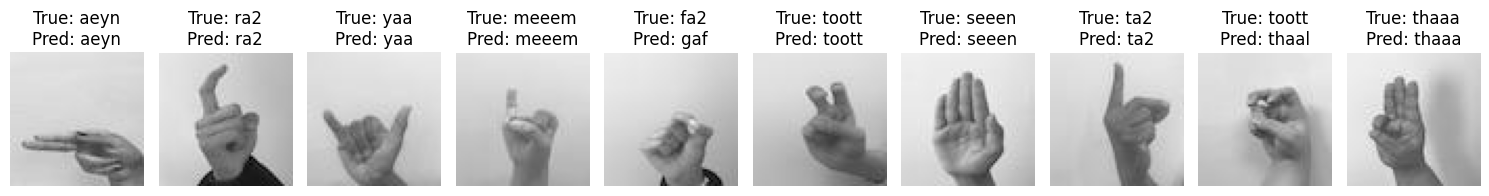

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# Define paths
test_base = '/kaggle/working/dataset/test'
model_path = '/content/best.pt'

# Load the trained YOLO model
model = YOLO(model_path)

# Function to get a random image path from the test set
def get_random_image_path(test_base):
    class_name = random.choice(os.listdir(test_base))
    class_path = os.path.join(test_base, class_name)
    image_name = random.choice(os.listdir(class_path))
    return os.path.join(class_path, image_name), class_name

# Get class names
class_names = sorted(os.listdir(test_base))

# Number of images to test
num_images_to_test = 10

# Collect paths of random test images
image_paths = []
true_classes = []
for _ in range(num_images_to_test):
    image_path, true_class = get_random_image_path(test_base)
    image_paths.append(image_path)
    true_classes.append(true_class)

# Predict with the model
results = model(image_paths)  # Run batched inference on the list of images

# Plot results
plt.figure(figsize=(15, 10))
for i, result in enumerate(results):
    # Extract predicted class index and name
    predicted_class_index = result.probs.top1
    predicted_class = class_names[predicted_class_index]

    # Load the image for display
    img = Image.open(image_paths[i]).convert('RGB')

    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_classes[i]}\nPred: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()
